## Compute DICE coefficient between two 3D SMPL meshes

In [9]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt

import os
import joblib

import torch
import smplx

### Save SMPL ouput as *.ply meshes

In [4]:
# Load SMPL model
model = smplx.create(model_path='models/smpl', model_type='smpl', gender='neutral', batch_size=1)

In [5]:
path = '/home/lea/trampo/4DHumans/outputs/results'
routine = '1_partie_0429_000'

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458',
           'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']

frame_idx = 206

def rotation_matrix_to_angle_axis(rotation_matrix):
    """
    Convert a batch of rotation matrices (N, 3, 3) to axis-angle (N, 3).
    """
    def _angle_axis_from_rotmat(R):
        cos_theta = (torch.diagonal(R, dim1=-2, dim2=-1).sum(-1) - 1) / 2
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
        theta = torch.acos(cos_theta)

        rx = R[..., 2, 1] - R[..., 1, 2]
        ry = R[..., 0, 2] - R[..., 2, 0]
        rz = R[..., 1, 0] - R[..., 0, 1]
        axis = torch.stack([rx, ry, rz], dim=-1)

        axis = axis / (2 * torch.sin(theta).unsqueeze(-1) + 1e-8)
        axis_angle = axis * theta.unsqueeze(-1)

        axis_angle[torch.isnan(axis_angle)] = 0.0
        return axis_angle

    return _angle_axis_from_rotmat(rotation_matrix)

for cam in cameras:
    results_path = path + f'/demo_{routine}-{cam}.pkl'
    results = joblib.load(results_path)

    frame = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg'

    detections = results[frame]['smpl']

    all_vertices = []
    all_faces = []
    offset = 0

    for id, output in enumerate(detections):
        pose = torch.tensor(output['body_pose'], dtype=torch.float32).unsqueeze(0)         # (1, 23, 3, 3)
        betas = torch.tensor(output['betas'], dtype=torch.float32).unsqueeze(0)             # (1, 10)
        global_orient = torch.tensor(output['global_orient'], dtype=torch.float32).unsqueeze(0)  # (1, 3, 3)
        transl = np.array(results[frame]['pose'][id][-3:], dtype=np.float32).reshape(1,3)

        body_pose_aa = rotation_matrix_to_angle_axis(pose).reshape(1, -1)        # (1, 69)
        global_orient_aa = rotation_matrix_to_angle_axis(global_orient).reshape(1, 3)  # (1, 3)

        output_smpl = model(
            betas=betas,
            body_pose=body_pose_aa,
            return_verts=True
        )

        vertices = output_smpl.vertices[0].detach().cpu().numpy()

        """ # Apply translation if available
        if transl is not None:
            vertices += transl """

        faces = model.faces + offset  # Shift face indices
        offset += vertices.shape[0]

        all_vertices.append(vertices)
        all_faces.append(faces)

    # Combine all into one mesh
    if all_vertices:
        all_vertices = np.vstack(all_vertices)
        all_faces = np.vstack(all_faces)

        combined_mesh = trimesh.Trimesh(all_vertices, all_faces, process=False)
        save_path = f"meshes/{routine}_{cam}_{frame_idx:06d}.ply"
        combined_mesh.export(save_path)

### Load data and compute score

In [6]:
def aligned_voxelization_full(meshes, pitch):
    """
    Voxelise plusieurs meshes dans un espace commun et retourne :
    - les matrices voxelisées alignées (0/1)
    - les voxel_meshes (as_boxes) alignés dans le monde réel
    """
    # 1. Trouver les bornes globales
    bounds = np.array([m.bounds for m in meshes])
    global_min = bounds[:, 0, :].min(axis=0)
    global_max = bounds[:, 1, :].max(axis=0)
    dims = np.ceil((global_max - global_min) / pitch).astype(int)
    shape = tuple(dims)

    voxel_matrices = []

    for mesh in meshes:
        # 2. Décaler dans le repère commun
        shifted = mesh.copy()
        shifted.apply_translation(-global_min)

        # 3. Voxelisation
        vox = shifted.voxelized(pitch).fill()
        mat = np.zeros(shape, dtype=np.uint8)

        indices = np.floor(vox.points / pitch).astype(int)
        for idx in indices:
            if np.all((0 <= idx) & (idx < dims)):
                mat[tuple(idx)] = 1

        voxel_matrices.append(mat)

    return voxel_matrices

def compute_dice(mats):
    intersection = np.sum(mats[0] & mats[1])
    total = np.sum(mats[0]) + np.sum(mats[1])
    dice = 2.0 * intersection / total if total > 0 else 1.0
    return dice

import pyvista as pv
pv.set_jupyter_backend("trame")
def plot_with_pyvista(meshes, voxel_matrices, pitch):
    import tempfile

    plotter = pv.Plotter()

    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10)[:3] for i in range(len(meshes)+1)]

    # --- Affichage des meshes originaux ---
    for i, mesh in enumerate(meshes):
        with tempfile.NamedTemporaryFile(suffix=".ply", delete=False) as tmp:
            mesh.export(tmp.name, file_type='ply')
            pv_mesh = pv.read(tmp.name)
            color_rgb = [int(255 * c) for c in colors[i]]
            plotter.add_mesh(pv_mesh, color=color_rgb, opacity=0.4)
            os.unlink(tmp.name)

    # --- Points de l'intersection des voxel_matrices ---
    intersection = voxel_matrices[0] & voxel_matrices[1]
    color = colors[2]
    
    indices = np.argwhere(intersection == 1)
    if len(indices) > 50000:
        indices = indices[np.random.choice(len(indices), 50000, replace=False)]
    points = indices * pitch
    cloud = pv.PolyData(points)
    color_rgb = [int(255 * c) for c in color]
    plotter.add_mesh(cloud, color=color_rgb, point_size=5, render_points_as_spheres=True)

    plotter.show()

In [8]:
# Load meshes
path = '/home/lea/trampo/metrics/meshes'
frame_idx = 206

meshes = [trimesh.load(os.path.join(path, f)) 
          for f in sorted(os.listdir(path)) if f.endswith(f'{frame_idx:06d}.ply')]

pitch = 0.01

# Compare all pairs and visualize
for i in range(len(meshes)):
    for j in range(i + 1, len(meshes)):
        meshes1 = meshes[i].split()
        meshes2 = meshes[j].split()

        print(cameras[i], '-', cameras[j])
        print(f'{len(meshes1)} - {len(meshes2)} detections')

        for i, mesh1 in enumerate(meshes1):
            best_dice = 0
            for j, mesh2 in enumerate(meshes2):

                mats = aligned_voxelization_full([mesh1, mesh2], pitch)
                dice = compute_dice(mats)

                if dice > best_dice:
                    best_dice = dice

            print(f"Best dice with {i}-{j} : {best_dice:.4f}")

                #plot_with_pyvista([mesh1, mesh2], mats, pitch)



Camera1_M11139 - Camera2_M11140
2 - 2 detections
Best dice with 0-1 : 0.4827
Best dice with 1-1 : 0.6675
Camera2_M11140 - Camera3_M11141
2 - 1 detections
Best dice with 0-0 : 0.5055
Best dice with 1-0 : 0.6920
Camera2_M11140 - Camera4_M11458
2 - 1 detections
Best dice with 0-0 : 0.4968
Best dice with 1-0 : 0.6966
Camera2_M11140 - Camera5_M11459
2 - 1 detections
Best dice with 0-0 : 0.4903
Best dice with 1-0 : 0.6638
Camera2_M11140 - Camera6_M11461
2 - 1 detections
Best dice with 0-0 : 0.5062
Best dice with 1-0 : 0.7421
Camera2_M11140 - Camera7_M11462
2 - 1 detections
Best dice with 0-0 : 0.4769
Best dice with 1-0 : 0.5887
Camera2_M11140 - Camera8_M11463
2 - 1 detections
Best dice with 0-0 : 0.4420
Best dice with 1-0 : 0.5979
Camera2_M11140 - Camera3_M11141
2 - 1 detections
Best dice with 0-0 : 0.5055
Best dice with 1-0 : 0.6920
Camera2_M11140 - Camera4_M11458
2 - 1 detections
Best dice with 0-0 : 0.4968
Best dice with 1-0 : 0.6966
Camera2_M11140 - Camera5_M11459
2 - 1 detections
Best d

Intersection voxels: 10966
Mesh1-only voxels: 86497
Mesh2-only voxels: 86370
Dice between mesh 0 and 1 = 0.1126


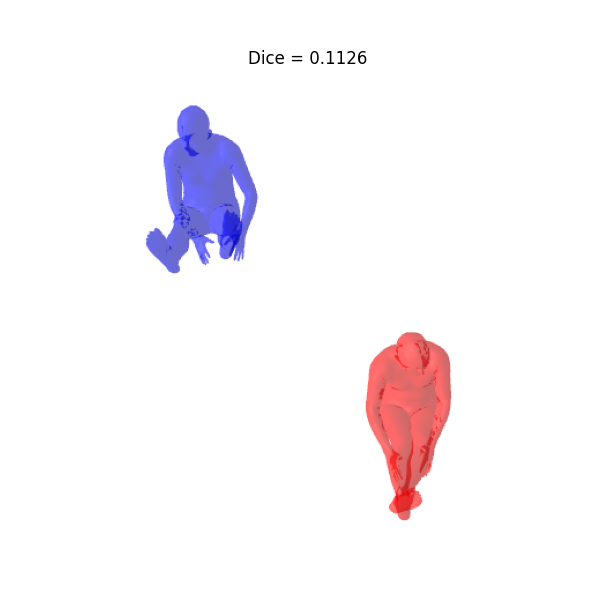

Intersection voxels: 3885
Mesh1-only voxels: 93578
Mesh2-only voxels: 93556
Dice between mesh 0 and 2 = 0.0399


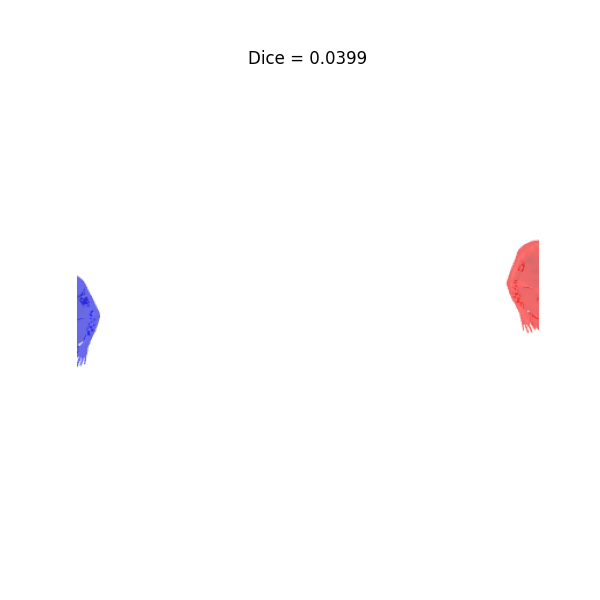

Intersection voxels: 3241
Mesh1-only voxels: 94222
Mesh2-only voxels: 93746
Dice between mesh 0 and 3 = 0.0333


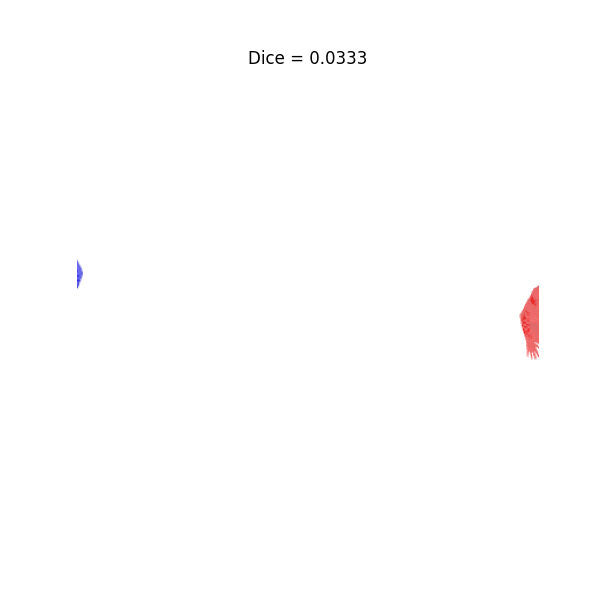

Intersection voxels: 6510
Mesh1-only voxels: 90953
Mesh2-only voxels: 93492
Dice between mesh 0 and 4 = 0.0659


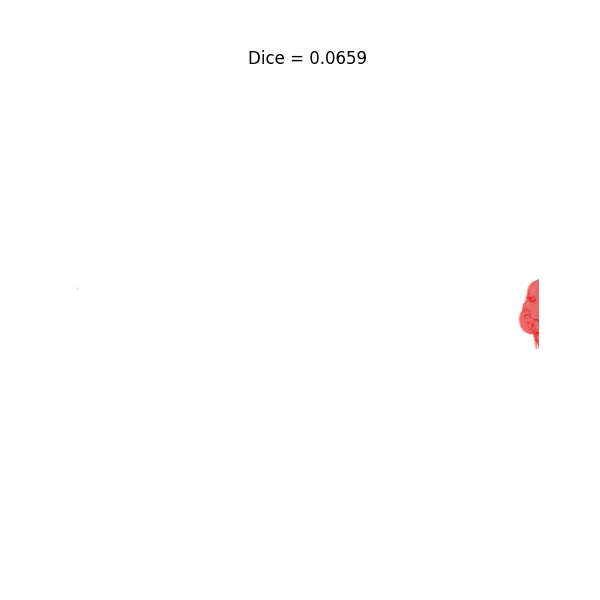

Intersection voxels: 113
Mesh1-only voxels: 97350
Mesh2-only voxels: 199022
Dice between mesh 0 and 5 = 0.0008


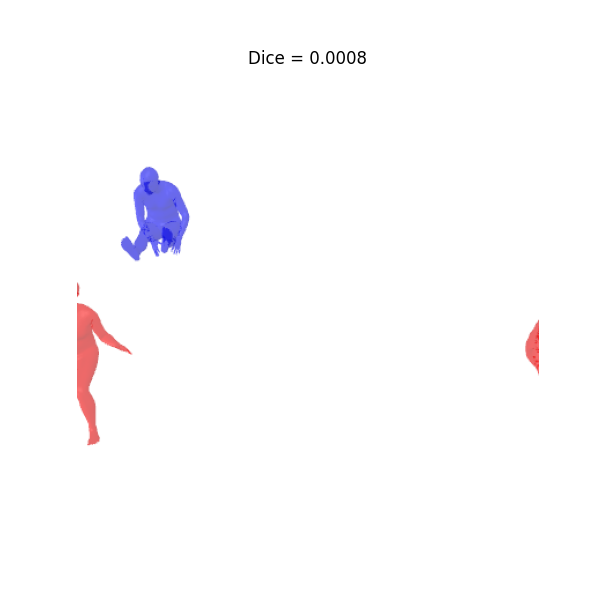

Intersection voxels: 777
Mesh1-only voxels: 96686
Mesh2-only voxels: 191401
Dice between mesh 0 and 6 = 0.0054


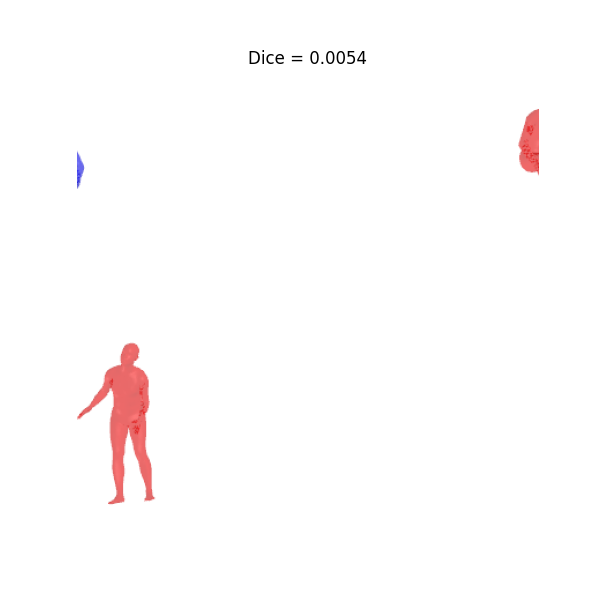

Intersection voxels: 4518
Mesh1-only voxels: 92945
Mesh2-only voxels: 97544
Dice between mesh 0 and 7 = 0.0453


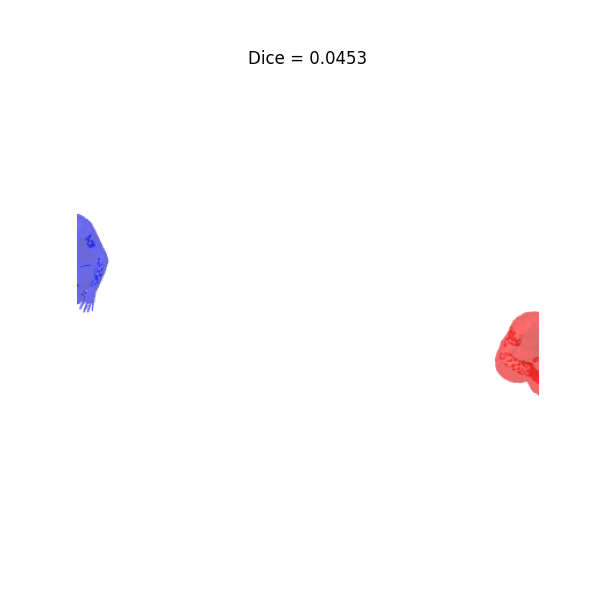

In [ ]:
import os
import trimesh
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from matplotlib.image import imread
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# --- Helper function to plot bounding boxes ---
def plot_wireframe_box(ax, min_corner, max_corner, color='black', linewidth=2):
    corners = np.array([
        [min_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], max_corner[1], max_corner[2]],
        [min_corner[0], max_corner[1], max_corner[2]],
    ])
    edges = [
        [corners[0], corners[1]], [corners[1], corners[2]], [corners[2], corners[3]], [corners[3], corners[0]],
        [corners[4], corners[5]], [corners[5], corners[6]], [corners[6], corners[7]], [corners[7], corners[4]],
        [corners[0], corners[4]], [corners[1], corners[5]], [corners[2], corners[6]], [corners[3], corners[7]],
    ]
    ax.add_collection3d(Line3DCollection(edges, colors=color, linewidths=linewidth))

# --- Load meshes ---
path = '/home/lea/trampo/metrics/meshes'
meshes = []

for file in os.listdir(path):
    if file.endswith('206.ply'):
        mesh = trimesh.load(os.path.join(path, file))
        meshes.append(mesh)

# --- Compare and visualize ---
for i in range(len(meshes)):
    for j in range(i + 1, len(meshes)):
        mesh1 = meshes[i]
        mesh2 = meshes[j]

        vox1 = voxelize(mesh1, pitch=0.005)
        vox2 = voxelize(mesh2, pitch=0.005)

        dice_score, padded1, padded2 = compute_dice(vox1, vox2)
        print("Intersection voxels:", np.sum(padded1 & padded2))
        print("Mesh1-only voxels:", np.sum(padded1 & ~padded2))
        print("Mesh2-only voxels:", np.sum(padded2 & ~padded1))
        print(f"Dice between mesh {i} and {j} = {dice_score:.4f}")

        # Visualization with bounding boxes
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

        # Visualization
        mesh1.visual.face_colors = [0, 0, 255, 150]  # Blue with transparency
        mesh2.visual.face_colors = [255, 0, 0, 150]  # Red with transparency

        # Render scene to image
        scene = trimesh.Scene([mesh1, mesh2])
        img_bytes = scene.save_image(resolution=(400, 400), visible=True)
        
        # Convert bytes directly to NumPy array (no PIL.Image.open needed)
        img_np = imread(BytesIO(img_bytes))
        ax.imshow(img_np)
        ax.set_title(f'Dice = {dice_score:.4f}')
        ax.axis('off')

        plt.show()

    break
